In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SchwiftyNotebook_Annealing")' SchwiftyNotebook_Annealing

Installing packages:
	.package(path: "/home/ubuntu/workspace/fast-ai-swift/SchwiftyNotebook_Annealing")
		SchwiftyNotebook_Annealing
With SwiftPM flags: []
Working in: /tmp/tmp560nfoar/swift-install
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information availabl

In [4]:
//export
import Path
import TensorFlow
import SchwiftyNotebook_Annealing

### Things Needed
----
- Layer Activations Statistics (mean/standard deviation)
- Optimization
- Learning Rate over Time

In [3]:
Array(1...10).enumerated().reversed().forEach {
    print($0, $1)
}

9 10
8 9
7 8
6 7
5 6
4 5
3 4
2 3
1 2
0 1


In [36]:
var yeetBoi = [1,2,3,4,5]
yeetBoi.insert(0, at:0)
yeetBoi

▿ 6 elements
  - 0 : 0
  - 1 : 1
  - 2 : 2
  - 3 : 3
  - 4 : 4
  - 5 : 5


In [4]:
protocol Fam {
    func fam()
}

extension Fam {
    func fam() {
        print("Fam")
    }
}

protocol Ravioli {
    func ravioli()
}

extension Ravioli {
    func ravioli() {
        print("Ravioli")
    }
}

struct FamRavioli: Fam, Ravioli {}

let famRav = FamRavioli()

famRav.fam()
famRav.ravioli()

Fam
Ravioli


## Model


In [44]:
//export
public struct HyperParameters {
    public let learningRate: Float
}

In [45]:
//export
public protocol TeachableModel {
    
    func apply(inputTensor: TensorFloat) -> TensorFloat
    
    func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel)
    
    func backwardsPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> TeachableModel    
}

In [46]:
//export
public protocol ModelParameterV2  {
    
    func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameterV2)
    
    func apply(_ inputTensor: TensorFloat) -> TensorFloat 
    
    func backwardPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> (TensorFloat, ModelParameterV2)
}

In [47]:
//export
public struct SequentialParameter: ModelParameterV2 {
    
    private let parameters: [ModelParameterV2]
    
    public func apply(_ inputTensor: TensorFloat) -> TensorFloat {
        return parameters.reduce(inputTensor) {
            (layerInput, nextParameter) in nextParameter.apply(layerInput)
        }
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameterV2) {
        return runThroughLayers({self.parameters}, inputTensor, {
            $0.append($1)
            return $0
        }) {
            $1.forwardPass(inputTensor: $0)
        }
    }
    
    public func backwardPass(ddx: TensorFloat, 
                             hyperParameters: HyperParameters) -> (TensorFloat, ModelParameterV2) {
        return runThroughLayers({self.parameters.reversed()}, ddx, {
            $0.insert($1, at: 0)
            return $0
        }) {
            $1.backwardPass(ddx: $0, hyperParameters: hyperParameters)
        }
    }
    
    
    private func runThroughLayers(
        _ parameterSupplier: () -> [ModelParameterV2],
        _ initialValue: TensorFloat,
        _ paramAccumulator: (inout [ModelParameterV2], ModelParameterV2) -> [ModelParameterV2],
        _ paramActivator: (TensorFloat, ModelParameterV2) -> (TensorFloat, ModelParameterV2)) 
                                                                            -> (TensorFloat, ModelParameterV2){
        var nextParamters : [ModelParameterV2] = []
        let (output, forwardParams) = parameterSupplier().reduce(
            (activations: initialValue, 
                           params:  nextParamters)) {
            (accum, nextParameter) in 
            var (activations, params) = accum
            let (nextInput, modifiedParam) = paramActivator(activations, nextParameter)
            return (activations: nextInput,
                    params: paramAccumulator(&params, modifiedParam))
        }

        return (output, SequentialParameter(parameters: forwardParams))
    }
    
}

In [48]:
//export
public struct ReLUParameter: ModelParameterV2 {
    
    private let gradientChain: (TensorFloat) -> TensorFloat
    
    public init() {
        gradientChain = { $0 }
    }
    
    private init(_ gradChain: @escaping (TensorFloat) -> TensorFloat) {
        gradientChain = gradChain
    }
    
    public func apply(_ inputTensor: TensorFloat) -> TensorFloat {
        return reLU(tensor: inputTensor)
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameterV2) {
        let (value, gradientDude) = reLUAndGradient(inputTensor: inputTensor)
        return (value, ReLUParameter(gradientDude))
    }
    
    public func backwardPass(ddx: TensorFloat,
                             hyperParameters: HyperParameters) -> (TensorFloat, ModelParameterV2) {
        let reluDDX = gradientChain(ddx)
        return (reluDDX, self)
    }
}

In [49]:
//export
public struct DenseLayerV2: ModelParameterV2 {
    let weightParameter: TensorFloat
    let biasParameter: TensorFloat
    private let gradientChain: ThreeInputGradient

    private init(weightParameter: TensorFloat,
                 biasParameter: TensorFloat,
                 gradientChain: @escaping ThreeInputGradient) {        
        self.weightParameter = weightParameter
        self.biasParameter = biasParameter
        self.gradientChain = gradientChain
    }

    private init(denseLayer: DenseLayerV2,
                 gradientChain: @escaping ThreeInputGradient) {
        self.weightParameter = denseLayer.weightParameter
        self.biasParameter = denseLayer.biasParameter
        self.gradientChain = gradientChain
    }

    public init(inputSize: Int,
                outputSize: Int){
        self.weightParameter = TensorFloat(kaimingUniform: TensorShape([inputSize, outputSize]))
        self.biasParameter = TensorFloat(zeros: [outputSize])
        self.gradientChain = { (x: TensorFloat)  in (TensorFloat([1]), TensorFloat([1]), TensorFloat([1]))}
    }

    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameterV2) {
        let (parameterOutput, parameterGradientChain) =
          linearCombinationAndGradient(inputTensor: inputTensor,
                                       weightParameter: self.weightParameter,
                                       biasParameter: self.biasParameter)

        return (parameterOutput, DenseLayerV2(denseLayer: self,
                                       gradientChain: {ddx in parameterGradientChain(ddx)}))
    }

    public func apply(_ inputTensor: TensorFloat) -> TensorFloat {
        return linearCombination(inputs: inputTensor,
                                       weights: self.weightParameter,
                                       bias: self.biasParameter)
    }

    public func backwardPass(ddx: TensorFloat, 
                             hyperParameters: HyperParameters) -> (TensorFloat, ModelParameterV2) {
        let (ddxInput, ddxParameter, ddxBias) = self.gradientChain(ddx)
        return (ddxInput, DenseLayerV2(
            weightParameter: self.weightParameter - hyperParameters.learningRate * ddxParameter,
            biasParameter: self.biasParameter - hyperParameters.learningRate * ddxBias,
            gradientChain: self.gradientChain))
    }
}



In [50]:
struct SimpleModel : TeachableModel {
    
    private let denseLayer: ModelParameterV2
    
    private init(denseLayer: ModelParameterV2){
        self.denseLayer = denseLayer
    }
    
    public init(inputSize: Int, 
                numberOfClasses: Int) {
        self.denseLayer = DenseLayerV2(inputSize: inputSize, 
                                       outputSize: numberOfClasses)
    }
    
    public func apply(inputTensor: TensorFloat) -> TensorFloat {
        return self.denseLayer.apply(inputTensor)
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel) {
        let (activations, newDenseLayer) = self.denseLayer.forwardPass(inputTensor: inputTensor)
        return (activations, SimpleModel(denseLayer: newDenseLayer))
    }
    
    public func backwardsPass(ddx: TensorFloat, 
                              hyperParameters: HyperParameters) -> TeachableModel {
        let (ddxDenseLayer, optimizedDenseLayer) = self.denseLayer.backwardPass(ddx: ddx, 
                                                          hyperParameters: hyperParameters)
        return SimpleModel(denseLayer: optimizedDenseLayer)
    }
}

In [200]:
struct SequentialModel : TeachableModel {
    
    private let sequentialParameter: ModelParameterV2
    
    private init(sequentialParameter: ModelParameterV2){
        self.sequentialParameter = sequentialParameter
    }
    
    public init(layerSizes: [Int]) {
        let denseLayers = layerSizes.prefix(upTo: layerSizes.count - 1)
                                        .enumerated()
                                        .flatMap { 
                                            (element: (Int, Int)) -> [ModelParameterV2] in                                       
                                            if(element.0 < layerSizes.count - 2){
                                               return [DenseLayerV2(inputSize: element.1, 
                                                               outputSize: layerSizes[element.0 + 1]), 
                                                ReLUParameter()]
                                            }
                                            else {
                                                return [
                                                    DenseLayerV2(inputSize: element.1, 
                                                               outputSize: layerSizes[element.0 + 1])
                                                ]
                                            }
                                        }
        self.sequentialParameter = SequentialParameter(parameters: denseLayers)
    }
    
    public func apply(inputTensor: TensorFloat) -> TensorFloat {
        return self.sequentialParameter.apply(inputTensor)
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel) {
        let (activations, newSequentialModel) = self.sequentialParameter
                                                        .forwardPass(inputTensor: inputTensor)
        return (activations, SequentialModel(sequentialParameter: newSequentialModel))
    }
    
    public func backwardsPass(ddx: TensorFloat, 
                              hyperParameters: HyperParameters) -> TeachableModel {
        let (_, optimizedSequentialLayer) = self.sequentialParameter.backwardPass(ddx: ddx, 
                                                          hyperParameters: hyperParameters)
        return SequentialModel(sequentialParameter: optimizedSequentialLayer)
    }
}

In [201]:
let testSequentialModel = SequentialModel(layerSizes: [8, 6, 3, 1])
testSequentialModel

▿ SequentialModel
  ▿ sequentialParameter : SequentialParameter
    ▿ parameters : 5 elements
      ▿ 0 : DenseLayerV2
        - weightParameter : [[ 0.036833346, -0.017076565,  -0.18239339,  -0.48359033,   0.37740242,   0.41008088],
 [ -0.34414852,  0.112788014,  -0.36153212,  0.025277805,   -0.5777518,   0.20539358],
 [  0.58502424,  -0.34639484,   -0.3540125,  -0.19593813,   -0.4560003, -0.084860146],
 [-0.040853407,   0.42985496,  -0.58750695,   0.28820336,   0.09411099,   0.02937773],
 [  -0.4092846,  -0.10879094,   0.26497066, -0.049555358,  -0.59314126,   0.12885067],
 [  0.48670447,   -0.3588516,    0.6081043,  -0.09323096,  -0.40144137,  -0.15431477],
 [  0.08343773,    0.2395308,  -0.25352624,  -0.07276557,  -0.39463976, -0.012968755],
 [  0.53552556,   0.24891582,   0.18849953,   0.57447946,  -0.45941943,  0.050549407]]
        - biasParameter : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        - gradientChain : (Function)
      ▿ 1 : ReLUParameter
        - gradientChain : (Function)


## Data

In [13]:
//export
public struct DataBunch<T> where T: TensorGroup {
    public let trainingDataset: Dataset<T>
    public let validationDataset: Dataset<T>
}

In [14]:
// export
public struct SupervisedLearningGroup {
    let features: TensorFloat
    let labels: TensorFloat
}

extension SupervisedLearningGroup: TensorGroup {
    
    public static var _typeList: [TensorDataType] = [
        Float.tensorFlowDataType,
        Float.tensorFlowDataType
    ]
    public static var _unknownShapeList: [TensorShape?] = [nil, nil]
    public var _tensorHandles: [_AnyTensorHandle] {
        fatalError("unimplemented")
    }
    public func _unpackTensorHandles(into address: UnsafeMutablePointer<CTensorHandle>?) {
        address!.advanced(by: 0).initialize(to: features.handle._cTensorHandle)
        address!.advanced(by: 1).initialize(to: labels.handle._cTensorHandle)
    }
    public init(_owning tensorHandles: UnsafePointer<CTensorHandle>?) {
        features = Tensor(handle: TensorHandle(_owning: tensorHandles!.advanced(by: 0).pointee))
        labels = Tensor(handle: TensorHandle(_owning: tensorHandles!.advanced(by: 1).pointee))
    }
    public init<C: RandomAccessCollection>(_handles: C) where C.Element: _AnyTensorHandle {
        fatalError("unimplemented")
    }
}

public extension Sequence where Element == SupervisedLearningGroup {
    var first: SupervisedLearningGroup? {
        return first(where: { _ in true })
    }
}

public extension Dataset where Element == SupervisedLearningGroup {
    init(featuresTensor: TensorFloat, labelsTensor: TensorFloat) {
        self.init(elements: SupervisedLearningGroup(
                                                    features: featuresTensor, 
                                                    labels: labelsTensor.expandingShape(at: 1)))
    }
}

In [15]:
import Python


## Teach

In [61]:
//export 
public protocol TeachingDelegate {
    
    func preTeach(epochs: Int)
    
    func postTeach()
    
    func preEpoch(epochNumber: Int, dataSet: Dataset<SupervisedLearningGroup>)
    
    func postEpoch(epochNumber: Int)
    
    func processBatch(model: TeachableModel, 
                      xDataPoints: TensorFloat,
                      yValidationPoints: TensorFloat) -> TeachableModel    
}

In [62]:
//export
public struct Teacher {
    
    private let dataBunch: DataBunch<SupervisedLearningGroup>
    private let trainingDelegate: TeachingDelegate
    private let validationDelegate: TeachingDelegate
    
    
    public func teachModel(model: TeachableModel,
                           numberOfEpochs: Int) -> TeachableModel {
        notifyPreTeach(epochs: numberOfEpochs)
        let taughtModel = (1...numberOfEpochs)
            .reduce(into: model) { (currentModel: inout TeachableModel, 
                                    epoch: Int) in
                let trainedModel = trainModel(modelToTeach: currentModel,
                                              currentEpoch: epoch)
                currentModel = validateModel(modelToValidate: trainedModel,
                                             currentEpoch: epoch)
            }
        notifyPostTeach()
        return taughtModel
    }
    
    private func trainModel(modelToTeach: TeachableModel, 
                            currentEpoch: Int) -> TeachableModel {
        return processDataSet(model: modelToTeach,
                           epoch: currentEpoch,
                           dataSet: dataBunch.trainingDataset,
                           teachingDelegate: trainingDelegate)
    }
    
    private func validateModel(modelToValidate: TeachableModel, 
                               currentEpoch: Int) -> TeachableModel {
        return processDataSet(model: modelToValidate,
                              epoch: currentEpoch,
                              dataSet: dataBunch.validationDataset,
                              teachingDelegate: validationDelegate)
    }
    
    private func processDataSet(model: TeachableModel,
                             epoch: Int,
                             dataSet: Dataset<SupervisedLearningGroup>,
                             teachingDelegate: TeachingDelegate
                            ) -> TeachableModel {
        
        teachingDelegate.preEpoch(epochNumber: epoch, 
                                  dataSet: dataSet)
        
        let taughtModel: TeachableModel = dataSet.reduce(model) {
            (currentModel:TeachableModel, dataGroup: SupervisedLearningGroup) in
            return teachingDelegate.processBatch(model: currentModel, 
                                                         xDataPoints: dataGroup.features, 
                                                         yValidationPoints: dataGroup.labels)
        }
        
        teachingDelegate.postEpoch(epochNumber: epoch)
        
        return taughtModel
    }
    
    
    private func notifyPreTeach(epochs: Int) {
        trainingDelegate.preTeach(epochs: epochs)
        validationDelegate.preTeach(epochs: epochs)
    }
    
    private func notifyPostTeach() {
        trainingDelegate.postTeach()
        validationDelegate.postTeach()
    }
}

## Teaching Delegates

In [63]:
//export
public protocol LossFunction {
    func lossAndGradient(expectedTensor: TensorFloat,
                         actualTensor: TensorFloat) -> (loss: TensorFloat,
                                                        gradientSupplier: () -> TensorFloat)
    func calculateLoss(expectedTensor: TensorFloat,
                       actualTensor: TensorFloat) -> TensorFloat
}

In [64]:
//export
public struct MeanSquaredErrorLossFunction: LossFunction {
        
    public func calculateLoss(expectedTensor: TensorFloat, 
                              actualTensor: TensorFloat) -> TensorFloat {
        let error: TensorFloat = calculateError(expectedTensor: expectedTensor,
                                   actualTensor: actualTensor)
        return error.squared().mean()
    }
    
    public func lossAndGradient(expectedTensor: TensorFloat, 
                                actualTensor: TensorFloat) -> (loss: TensorFloat, 
                                                               gradientSupplier: () -> TensorFloat) {
        let error = calculateError(expectedTensor:expectedTensor, 
                                   actualTensor: actualTensor)
        let (squareValue, squareGradient) = squaredWithGradient(inputTensor: error)
        let (meanValue, meanGradient) = meanWithGradient(inputTensor: squareValue)

        return (loss: meanValue, gradientSupplier: { squareGradient(meanGradient(TensorFloat([1]))) })
    }
    
    private func calculateError(expectedTensor: TensorFloat,
                                actualTensor: TensorFloat) -> TensorFloat {
        assert(expectedTensor.shape == actualTensor.shape, "Expected \(expectedTensor.shape) to be the same as \(actualTensor.shape)")
        return actualTensor - expectedTensor // order is SUPER important here
    }
}

In [177]:
class ValidationDelegate: TeachingDelegate {
    
    let lossFunction: LossFunction
    
    public init(lossFunction: LossFunction) {
        self.lossFunction = lossFunction
    }
    
    private var epochNumber: Int = 0
    private var numberOfBatches: Int = 0
    private var totalLoss: TensorFloat = TensorFloat([0.0])
    var lossCount: [Float] = []
    
    public func postEpoch(epochNumber: Int) {
        let loss = totalLoss / Float(numberOfBatches) 
        lossCount.append(loss.scalarized())
        
    }
    
    public func preEpoch(epochNumber: Int, 
                         dataSet: Dataset<SupervisedLearningGroup>) {
        numberOfBatches = 0
        totalLoss = TensorFloat([0.0])
    }
    
    public func preTeach(epochs: Int) {
    
    }
    
    public func postTeach() {
    
    }
    
    
    public func processBatch(model: TeachableModel, 
                             xDataPoints: TensorFloat, 
                             yValidationPoints: TensorFloat) -> TeachableModel {

        let predictions = model.apply(inputTensor: xDataPoints)
        
        let loss = lossFunction.calculateLoss(expectedTensor: yValidationPoints, 
                                                                    actualTensor: predictions)
        totalLoss += loss
        numberOfBatches += 1
        
        return model
    }
    
}

In [66]:
class TrainingDelegate: TeachingDelegate {
    
    let lossFunction: LossFunction
    
    public init(lossFunction: LossFunction) {
        self.lossFunction = lossFunction
    }
    
    private var epochNumber: Int = 0
    private var numberOfBatches: Int = 0
    private var totalLoss: TensorFloat = TensorFloat([0.0])
    var lossCount: [Float] = []
    
    public func postEpoch(epochNumber: Int) {
        let loss = totalLoss / Float(numberOfBatches)
        lossCount.append(loss.scalarized())
    }
    
    public func preEpoch(epochNumber: Int, 
                         dataSet: Dataset<SupervisedLearningGroup>) {
        numberOfBatches = 0
        totalLoss = TensorFloat([0.0])
    }
    
    public func preTeach(epochs: Int) {
    
    }
    
    public func postTeach() {
    
    }
    
    
    public func processBatch(model: TeachableModel, 
                             xDataPoints: TensorFloat, 
                             yValidationPoints: TensorFloat) -> TeachableModel {

        let (predictions, modelWithChain) = model.forwardPass(inputTensor: xDataPoints)
        
        let (lossyBoi, predictionGradientSupplier) = lossFunction.lossAndGradient(expectedTensor: yValidationPoints, 
                                                                    actualTensor: predictions)
        
        totalLoss += lossyBoi
        numberOfBatches += 1
        
        // todo: Optimize Hyper Parameters beforehand
        let hyperParameters = HyperParameters(learningRate: 1e-2)
        
        return modelWithChain.backwardsPass(ddx: predictionGradientSupplier(),
                                            hyperParameters: hyperParameters)
    }
    
}

# Point Data Trials
---

In [67]:
let n = 100
let inputPoints = TensorFloat(randomNormal: [100, 1])
let A = inputPoints.concatenated(with: TensorFloat(ones: inputPoints.shape), alongAxis: 1)
A.shape

▿ [100, 2]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 2


In [68]:
let yValidationPoints = matmul(A, TensorFloat([-2, 7]).expandingShape(at: 1)) + 
                (TensorFloat(randomNormal: inputPoints.shape, seed: (69, 420)) * 2.5)
yValidationPoints.shape

▿ [100, 1]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 1


In [69]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [70]:
public let plotter = Python.import("matplotlib.pyplot")

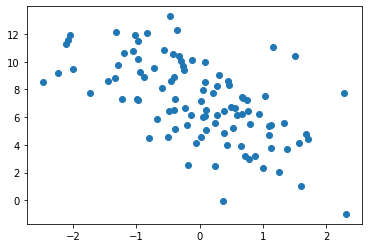

None


In [71]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
plotter.show()

In [72]:
func showYHat(yHat: TensorFloat) {
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yHat.makeNumpyArray())
    plotter.show()
}

In [202]:
let linearModel = SequentialModel(layerSizes: [2, 1])
linearModel

▿ SequentialModel
  ▿ sequentialParameter : SequentialParameter
    ▿ parameters : 1 element
      ▿ 0 : DenseLayerV2
        - weightParameter : [[-0.84218454],
 [ 0.10451611]]
        - biasParameter : [0.0]
        - gradientChain : (Function)


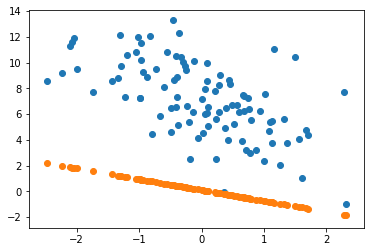

In [203]:
showYHat(yHat: linearModel.apply(inputTensor: A))

In [204]:
//export
public extension Dataset where Element == SupervisedLearningGroup {
    init(featureTensor: TensorFloat, labelTensor: TensorFloat) {
        self.init(elements: SupervisedLearningGroup(features: featureTensor, 
                                     labels: labelTensor))
    }
}

In [205]:
let linearDataSet = Dataset(featureTensor: A, labelTensor: yValidationPoints).batched(100)
let linearDataBunch = DataBunch(trainingDataset: linearDataSet,
                               validationDataset: linearDataSet)

In [206]:
let meanSquaredLossFunction = MeanSquaredErrorLossFunction()
let simpleTrainingDelegate = TrainingDelegate(lossFunction: meanSquaredLossFunction)
let simpleValidationDelegate = ValidationDelegate(lossFunction: meanSquaredLossFunction)

In [207]:
let linearTeacher = Teacher(dataBunch: linearDataBunch, 
                            trainingDelegate: simpleTrainingDelegate, 
                            validationDelegate: simpleValidationDelegate)

In [208]:
let taughtLinearModel = linearTeacher.teachModel(model: linearModel, 
                                                 numberOfEpochs: 100)

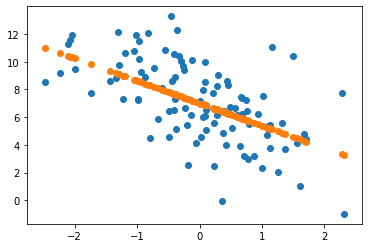

In [209]:
showYHat(yHat: taughtLinearModel.apply(inputTensor: A))

In [210]:
func plotLoss(lossArray: [Float]){
    plotter.figure(figsize: [12, 8])

    let lossAxes = plotter.subplot(2, 1, 2)
    lossAxes.set_ylabel("Loss")
    lossAxes.set_xlabel("Epoch")
    lossAxes.plot(lossArray)

    plotter.show()
}

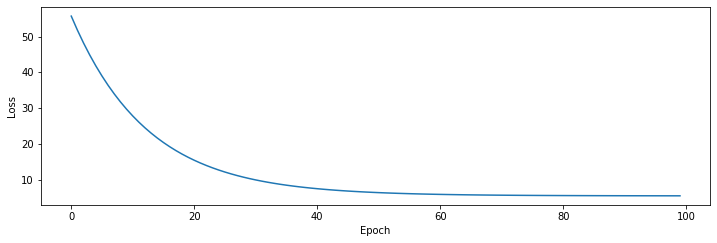

In [211]:
plotLoss(lossArray: simpleTrainingDelegate.lossCount)

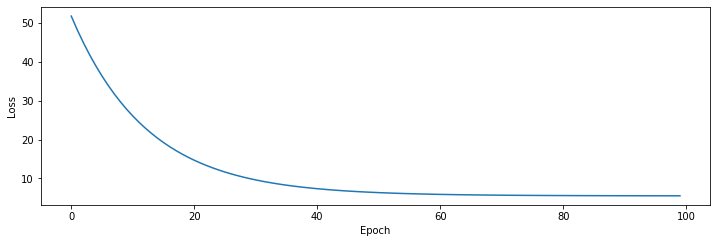

In [212]:
plotLoss(lossArray: simpleValidationDelegate.lossCount)

----

# Car Data!
----

In [84]:
//export
let carDataYCSV = "/home/ubuntu/.machine-learning/data/car_stuff/pakistan_car_labels.csv"
let carDataXCSV = "/home/ubuntu/.machine-learning/data/car_stuff/pakistan_car_x_data.csv"

public let numpy = Python.import("numpy")

func createDataSet(featureTensor: TensorFloat, 
                   labelTensor: TensorFloat, 
                   batchSize: Int) -> Dataset<SupervisedLearningGroup> {
    return Dataset(featuresTensor: featureTensor, labelsTensor: labelTensor)
                    .batched(batchSize)
                    .shuffled(sampleCount: 64, 
                              randomSeed: 69, 
                              reshuffleForEachIterator: true)
}

public func getUsedCarDataBunch(validationSize: Double = 0.2,
                             batchSize: Int = 1028
                            ) -> DataBunch<SupervisedLearningGroup> {
    let usedCarFeaturesArray = numpy.loadtxt(carDataXCSV, 
                                delimiter: ",", 
                                skiprows: 1, 
                                usecols: Array(1...8), 
                                dtype: Float.numpyScalarTypes.first!)
    let categoricalVariableSet: Set = [0,1,2,3,4,5,6,7]
    let continousVariableSet: Set = [-1]
    let usedCarFeatureTensor = reScaleFeatures(featureTensor: TensorFloat(numpy: usedCarFeaturesArray)!, 
                                               catVars: categoricalVariableSet, 
                                               contVars: continousVariableSet)
    
    let usedCarPrices = numpy.loadtxt(carDataYCSV, 
                                delimiter: ",", 
                                skiprows: 0, 
                                usecols: [1], 
                                dtype: Float.numpyScalarTypes.first!)
    let usedCarLabelsTensor = TensorFloat(numpy: usedCarPrices)!
    
    let numberOfUsedCars = usedCarFeatureTensor.shape[0]
    let numberOfUsedCarFeatures = usedCarFeatureTensor.shape[1]
    
    let validationDatasetSize = Int32(floor(validationSize * Double(numberOfUsedCars)))
    let trainingDataSetSize = Int32(numberOfUsedCars) - validationDatasetSize
    
    
    let splitFeatures = usedCarFeatureTensor
                                .split(sizes: Tensor<Int32>([validationDatasetSize, trainingDataSetSize]), 
                                       alongAxis: 0)
    let splitLabels = usedCarLabelsTensor
                            .split(sizes: Tensor<Int32>([validationDatasetSize, trainingDataSetSize]), 
                                   alongAxis: 0)
    
    let validationDataSet = createDataSet(featureTensor: splitFeatures[0],
                                        labelTensor: splitLabels[0], batchSize: batchSize)
    let trainingDataSet = createDataSet(featureTensor: splitFeatures[1],
                                        labelTensor: splitLabels[1], batchSize: batchSize)
    return DataBunch(trainingDataset: trainingDataSet, 
                     validationDataset: validationDataSet)
}

In [85]:
let usedCarDataBunch = getUsedCarDataBunch()

# Car Data Test

In [213]:
let meanSquaredErrorLossy = MeanSquaredErrorLossFunction()
let protoTrainingDelegate = TrainingDelegate(lossFunction: meanSquaredErrorLossy)
let protoValidationDelegate = ValidationDelegate(lossFunction: meanSquaredErrorLossy)

In [214]:
let protoModelTeacher = Teacher(dataBunch: usedCarDataBunch, 
                                trainingDelegate: protoTrainingDelegate, 
                                validationDelegate: protoValidationDelegate)

In [215]:
let firstValidationBatch = usedCarDataBunch.validationDataset.first!
let firstTrainingBatch = usedCarDataBunch.trainingDataset.first!

let simpleUntrainedModel = SequentialModel(layerSizes: [
    firstValidationBatch.features.shape[1],
    firstValidationBatch.features.shape[1]/2,
    1
])
simpleUntrainedModel

▿ SequentialModel
  ▿ sequentialParameter : SequentialParameter
    ▿ parameters : 3 elements
      ▿ 0 : DenseLayerV2
        - weightParameter : [[  0.38012317,   0.27906778,   0.37507394,  -0.28468022],
 [ 0.111306764,   -0.3370277,  -0.15459152,   0.02249561],
 [  0.15841667,    0.5542161,   -0.1635973,  -0.35405177],
 [  0.12861627,   0.36750767,   0.30012587,  -0.34073618],
 [  0.22558945,    0.3488112,   0.20855844,  -0.33686554],
 [ -0.23900768,   -0.4114249, -0.105945535,  0.093184605],
 [ -0.42090774,  0.024430707, -0.035234634,   0.43934372],
 [ -0.19836313,    0.4743787,   0.54844683,   0.48398447]]
        - biasParameter : [0.0, 0.0, 0.0, 0.0]
        - gradientChain : (Function)
      ▿ 1 : ReLUParameter
        - gradientChain : (Function)
      ▿ 2 : DenseLayerV2
        - weightParameter : [[-0.52788204],
 [ 0.17080173],
 [ -0.8324836],
 [-0.80468583]]
        - biasParameter : [0.0]
        - gradientChain : (Function)


In [216]:
let predictions = simpleUntrainedModel.apply(inputTensor: firstValidationBatch.features)
meanSquaredErrorLossy.calculateLoss(expectedTensor: firstValidationBatch.labels, 
                                    actualTensor: predictions)

1.635975e+12


In [217]:
let testPreds = testSequentialModel.apply(inputTensor: firstValidationBatch.features)
meanSquaredErrorLossy.calculateLoss(expectedTensor: firstValidationBatch.labels, 
                                    actualTensor: testPreds)

1.6359752e+12


In [218]:
let simpleTrainedModel = withTime { 
    protoModelTeacher.teachModel(model: simpleUntrainedModel, 
                                                      numberOfEpochs: 100)
                                  }

elapsed time: 12.318718486 s


In [219]:
let predictions = simpleTrainedModel.apply(inputTensor: firstValidationBatch.features)
meanSquaredErrorLossy.calculateLoss(expectedTensor: firstValidationBatch.labels, 
                                    actualTensor: predictions)

8.4722654e+11


In [220]:
let predictions = simpleTrainedModel.apply(inputTensor: firstTrainingBatch.features)
meanSquaredErrorLossy.calculateLoss(expectedTensor: firstTrainingBatch.labels, 
                                    actualTensor: predictions)

7.813652e+12


In [224]:
usedCarDataBunch.trainingDataset.reduce(simpleTrainedModel){
    let predictions = $0.apply(inputTensor: $1.features)
    let lossBoi = meanSquaredErrorLossy.calculateLoss(expectedTensor: $1.labels, 
                                    actualTensor: predictions)
    print(lossBoi)
    return $0
}

7.813652e+12
9.718131e+11
7.440386e+11
1.6784907e+13
1.09278206e+12
8.10965e+11
7.580418e+11
8.3467954e+11
7.2892364e+11
3.3467093e+12
1.2441564e+12
1.0028363e+12
1.8302243e+12
1.1889159e+13
1.2560199e+12
9.5393356e+11
5.3671907e+11
7.0035676e+11
4.7862078e+11
5.8798696e+11


▿ SequentialModel
  ▿ sequentialParameter : SequentialParameter
    ▿ parameters : 3 elements
      ▿ 0 : DenseLayerV2
        - weightParameter : [[    -681.85004,  -4.960264e+08,     -1868.5995,      -1027.928],
 [    -664.14496,  -6.177444e+08,     -1932.6035,     -3344.3953],
 [     -593.9924, -1.4259804e+09,     -2537.5442,     -3883.5298],
 [    -414.69275,  -6.243587e+08,     -2476.6934,     -2520.5605],
 [    -176.59518, -2.2975771e+08,     -1843.0461,     -2195.2153],
 [    -530.98425, -3.5617834e+08,     -876.98773,     -58.317017],
 [     -315.8628, -4.2456932e+09,     -8025.0596,     -17140.852],
 [    -1.8524673,  -6.718085e+07,      -73.50013,     -124.91386]]
        - biasParameter : [     -847.7722, -4.4523976e+09,      -8902.007,     -17217.234]
        - gradientChain : (Function)
      ▿ 1 : ReLUParameter
        - gradientChain : (Function)
      ▿ 2 : DenseLayerV2
        - weightParameter : [[      493.2955],
 [-6.8704686e+09],
 [      936.0534],
 [     5475.5977

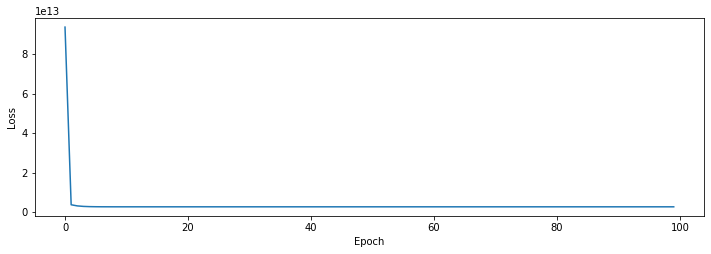

In [225]:
plotLoss(lossArray: protoTrainingDelegate.lossCount)

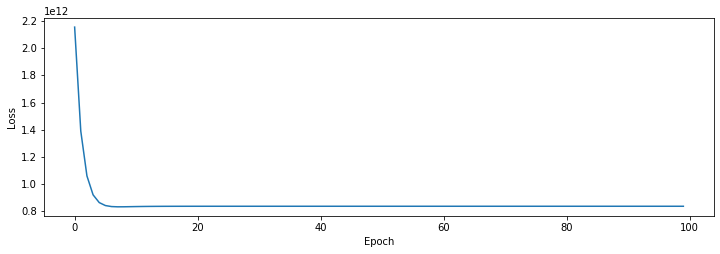

In [226]:
plotLoss(lossArray: protoValidationDelegate.lossCount)

# Tensor Flow Stuff

In [227]:
let inputSize = firstValidationBatch.features.shape[1]
let hiddenSize = inputSize - 2


struct UsedCarModel: Layer {
    var layer1 = Dense<Float>(inputSize: inputSize, outputSize: inputSize / 2, activation: relu)
    var layer2 = Dense<Float>(inputSize: inputSize / 2, outputSize: 1)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2)
    }
}

In [228]:
var model = UsedCarModel()

In [229]:
let firstTrainPredictions = model(firstValidationBatch.features)
firstTrainPredictions[0..<5]

[[0.28142703],
 [ 0.8486508],
 [ 0.8803416],
 [ 0.4423133],
 [ 0.4423133]]


In [230]:
let libLoss = meanSquaredError(predicted: firstTrainPredictions, expected:firstValidationBatch.labels)
libLoss

1.6359741e+12


In [231]:
let (myLoss, myGrad) = meanSquaredErrorAndGradient(yHat: firstTrainPredictions, y: firstValidationBatch.labels)
myLoss

1.6359741e+12


In [232]:
let optimizer = SGD(for: model, learningRate: 1e-2)

In [233]:
let (libLoss2, libGrads) = model.valueWithGradient {
    model -> TensorFloat in
    let libPreds = model(firstValidationBatch.features)
    return meanSquaredError(predicted: libPreds, expected: firstValidationBatch.labels)
}
libLoss2

1.6359741e+12


In [234]:
optimizer.update(&model.allDifferentiableVariables, along: libGrads)

In [235]:
let libLossEnhanced = meanSquaredError(predicted: model(firstValidationBatch.features), 
                                       expected:firstValidationBatch.labels)
libLossEnhanced

5.3331343e+16


In [236]:
func accuracy(expected: TensorFloat, actual: TensorFloat) -> Float {
    return (actual - expected).mean().scalarized()
}

In [237]:
let epochCount = 100
var trainingLoss: [Float] = []

In [238]:
var model3 = UsedCarModel()

In [239]:
let optimizer = SGD(for: model3, learningRate: 1e-2)

In [240]:
withTime { 
    for epoch in 1...100 {
        var epochLoss: Float = 0
        var epochAccuracy: Float = 0
        var batchCount: Int = 0

        for dataGroup in usedCarDataBunch.trainingDataset {
            let (loss, libraryGradients) = model3.valueWithGradient {
                model -> TensorFloat in
                let libPreds = model(dataGroup.features)
                return  meanSquaredError(predicted: libPreds, expected: dataGroup.labels)
            }

            optimizer.update(&model3.allDifferentiableVariables, along: libraryGradients)

            let preds = model(dataGroup.features)
            let batchAccuracy = accuracy(expected: dataGroup.labels, 
                                      actual: preds)
            let batchLoss = loss.scalarized()
            epochAccuracy += batchAccuracy
            epochLoss += batchLoss

            batchCount += 1
        }
        trainingLoss.append(epochLoss / Float(batchCount))
    }
}

elapsed time: 15.173458106 s


In [241]:
14.845449664 / 12.98729881

1.1430744669221944


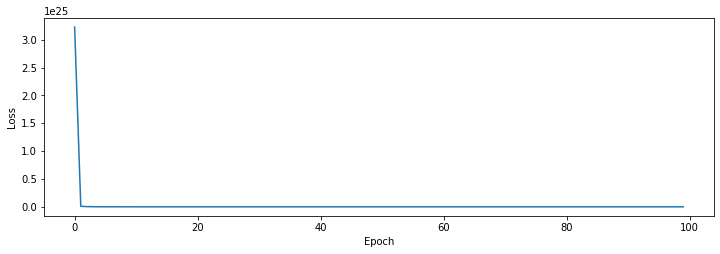

In [242]:
plotLoss(lossArray: trainingLoss)

In [246]:
let firstValidationBatch = usedCarDataBunch.validationDataset.first!
let myFinalLoss = meanSquaredError(predicted: simpleTrainedModel.apply(inputTensor: firstValidationBatch.features), 
                                   expected: firstValidationBatch.labels)
let tfFinalLoss = meanSquaredError(predicted: model3(firstValidationBatch.features), 
                                   expected: firstValidationBatch.labels)

print(myFinalLoss, tfFinalLoss, myFinalLoss <= tfFinalLoss)

8.4722654e+11 8.4722654e+11 true


In [249]:
usedCarDataBunch.trainingDataset.reduce(model3){
    let predictions = $0($1.features)
    let lossBoi = meanSquaredErrorLossy.calculateLoss(expectedTensor: $1.labels, 
                                    actualTensor: predictions)
    
    let myPredictions = simpleTrainedModel.apply(inputTensor: $1.features)
    let myLoss = meanSquaredErrorLossy.calculateLoss(expectedTensor: $1.labels, 
                                    actualTensor: myPredictions)
    print(myLoss - lossBoi)
    return $0
}

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


▿ UsedCarModel
  ▿ layer1 : Dense<Float>
    - weight : [[-7.8692425e+17,     -4.3170557,      -360.7915,     -423.30722],
 [ -8.554459e+17,     -0.6358264,     -228.63954,      -878.4773],
 [ -2.247417e+18,       -33.8069,    -126.987465,      -990.3059],
 [-9.5107234e+17,     -16.443157,     -272.56567,     -691.33374],
 [-3.6095067e+17,     -10.149123,     -20.280005,      -518.5785],
 [ -5.547963e+17,     -31.430605,     -0.3343822,     -174.81282],
 [ -6.184305e+18,      -12.04814,      -623.7323,     -3577.5461],
 [  -8.50168e+16,     -10.726803,     -4.2365017,     -26.205023]]
    - bias : [-6.6199116e+18,      -42.12668,      -626.6133,     -3753.1375]
    - activation : (Function)
  ▿ layer2 : Dense<Float>
    - weight : [[-9.810571e+17],
 [    17.251116],
 [     260.8562],
 [    10865.286]]
    - bias : [923109.3]
    - activation : (Function)


# 🤨

![weird](https://external-preview.redd.it/Ac-PqYwJtp2M_cC2MctlPHJywidGSu9rBh2AsUO_a4A.jpg?auto=webp&s=4775fedb64e4a69ec301828a2720af9d591ce44e)

# Tensorflow simple

In [250]:
struct SimpleModelTF: Layer {
    var layer1 = Dense<Float>(inputSize: 2, outputSize: 1)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return layer1(input)
    }
}

In [251]:
var tfSimpleModel = SimpleModelTF()

In [252]:
let optimizerTF = SGD(for: tfSimpleModel, learningRate: 1e-2)

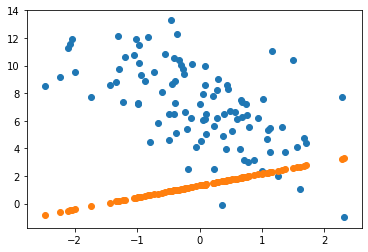

In [253]:
showYHat(yHat: tfSimpleModel(A))

In [254]:
var simpleTrainingAccuracy: [Float] = []
var simpleTrainingLoss: [Float] = []

In [255]:
for epoch in 1...50 {
    var epochLoss: Float = 0
    var epochAccuracy: Float = 0
    var batchCount: Int = 0
    
    for dataGroup in linearDataBunch.trainingDataset {
        let (loss, libraryGradients) = tfSimpleModel.valueWithGradient {
            model -> TensorFloat in
            let libPreds = model(dataGroup.features)            
            return  meanSquaredError(predicted: libPreds, expected: dataGroup.labels)
        }
        
        optimizerTF.update(&tfSimpleModel.allDifferentiableVariables, along: libraryGradients)
        
        let preds = tfSimpleModel(dataGroup.features)
        let batchAccuracy = accuracy(expected: dataGroup.labels, 
                                  actual: preds)
        let batchLoss = loss.scalarized()
        
        simpleTrainingAccuracy.append(batchAccuracy)
        simpleTrainingLoss.append(batchLoss)
    }
}

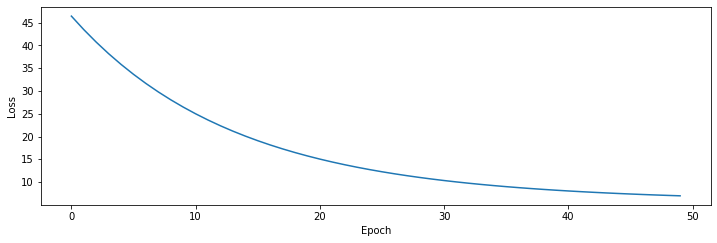

In [256]:
plotLoss(lossArray: simpleTrainingLoss)

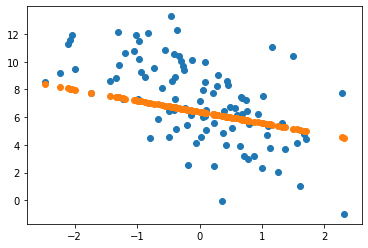

In [257]:
showYHat(yHat: tfSimpleModel(A))